In [142]:
import copy
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D

import config

In [143]:
GROUP_LABELS = ['Golden', 'Synthetic: Backward', 'Synthetic: Forward', 'Synthetic: Backward → Forward',
                'Synthetic: All']

In [144]:
def load_data(s):
    with open(config.OUTPUT_CHARTS_DIR / f"{s}_data.pkl", 'rb') as f:
        groups = pickle.load(f)

        data = []
        for i, group in enumerate(groups):
            for e in group:
                data.append({
                    'Subset': GROUP_LABELS[i],
                    'value': e
                })
        return pd.DataFrame.from_records(data)

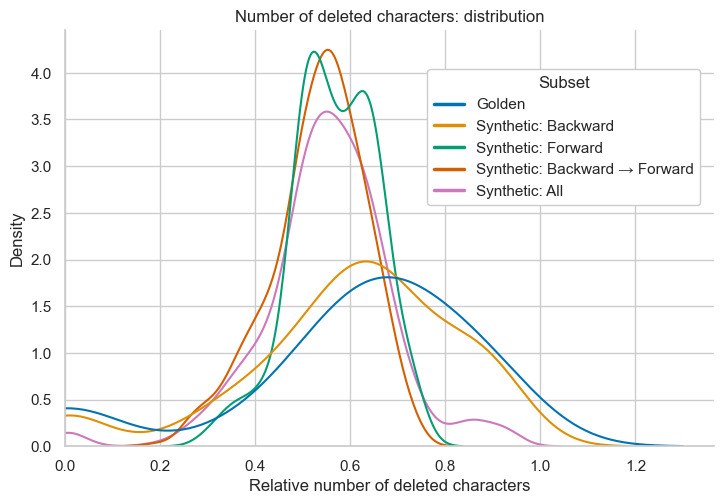

In [145]:
name = 'deletions_norm'

sns.set_theme(palette="colorblind", style='whitegrid')

ax = sns.displot(data=load_data(name),
                 x='value',
                 hue='Subset',
                 kind='kde',
                 aspect=1.5,
                 common_norm=False,
                 clip=(0, 10000))

ax.set(xlim=(0, None))
sns.move_legend(ax, "center right", bbox_to_anchor=(.70, .75), frameon=True, framealpha=1.)
for line in ax.legend.get_lines():
    line.set_linewidth(2.5)

plt.title("Number of deleted characters: distribution")
plt.xlabel("Relative number of deleted characters")

plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_dist.png", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_dist.svg", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_dist.pdf", bbox_inches='tight')
plt.show()

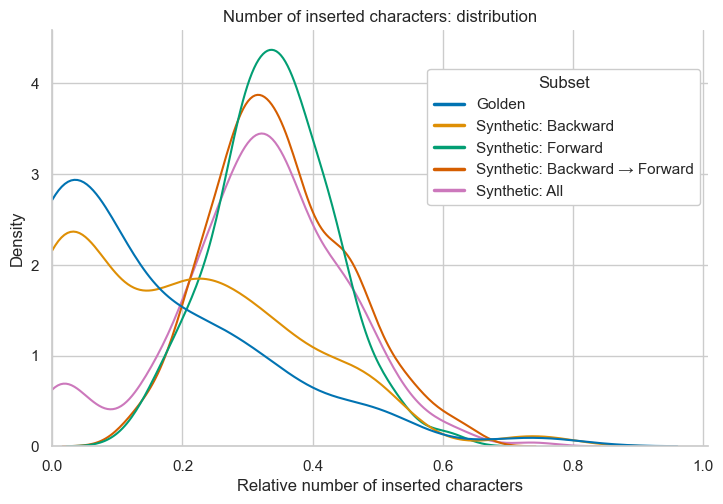

In [146]:
name = 'insertions_norm'

sns.set_theme(palette="colorblind", style='whitegrid')

ax = sns.displot(data=load_data(name),
                 x='value',
                 hue='Subset',
                 kind='kde',
                 aspect=1.5,
                 common_norm=False,
                 clip=(0, 10000))

ax.set(xlim=(0, None))


sns.move_legend(ax, "center right", bbox_to_anchor=(.70, .75), frameon=True, framealpha=1.)
for line in ax.legend.get_lines():
    line.set_linewidth(2.5)

plt.title("Number of inserted characters: distribution")
plt.xlabel("Relative number of inserted characters")

plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_dist.png", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_dist.svg", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_dist.pdf", bbox_inches='tight')
plt.show()

In [147]:
import numpy as np


def get_bins_for_report(intervals):
    bins = []
    for cur_interval in intervals:
        bins += list(map(int, np.linspace(start=cur_interval[0], stop=cur_interval[1], num=cur_interval[2])))
    print(",".join(list(map(str, bins))))


get_bins_for_report([
    (0, 400, 30),
    (401, 1200, 20)
])

0,13,27,41,55,68,82,96,110,124,137,151,165,179,193,206,220,234,248,262,275,289,303,317,331,344,358,372,386,400,401,443,485,527,569,611,653,695,737,779,821,863,905,947,989,1031,1073,1115,1157,1200


## FUS logs

In [148]:
def to_hist(data):
    data = data.copy()
    num_samples = sum(data['y'])
    data['y'] = [e / num_samples / scale for e, scale in zip(data['y'], data['bin_size'])]

    return data

In [149]:
FUS_REPORT_TYPE = "pycharm"

RAW_FUS_REPORT = f"data/fus_raw_report_{FUS_REPORT_TYPE}.csv"

FUS_METRICS = ["CommitMessageEditDistance", "CommitMessageLengthDiff"]

FUS_DATA = {}

for metric in FUS_METRICS:
    FUS_DATA[metric] = {"x": [], "y": [], "bin_size": []}

with open(RAW_FUS_REPORT, "r") as f:
    current_metric = None
    for line in f.readlines():
        if line.isspace():
            current_metric = None
            continue

        skip_line = False

        for metric in FUS_METRICS:
            if metric in line:
                current_metric = metric
                skip_line = True
                break

        if not skip_line and current_metric is not None:
            tokens = line.strip().split(",")
            interval = tokens[0].replace("> ", "").split(" - ")
            x_left = float(interval[0])
            x_right = float(interval[-1])
            x = (x_left + x_right) / 2
            y = float(tokens[-2])
            bin_size = x_right - x_left + 1
            FUS_DATA[current_metric]["x"].append(x)
            FUS_DATA[current_metric]["y"].append(y)
            FUS_DATA[current_metric]["bin_size"].append(bin_size)

SKIP_FIRST = 1
FUS_DATA_NO_HEAD = {}

for metric in FUS_METRICS:
    FUS_DATA_NO_HEAD[metric] = {
        'x': FUS_DATA[metric]['x'][SKIP_FIRST:],
        'y': FUS_DATA[metric]['y'][SKIP_FIRST:],
        'bin_size': FUS_DATA[metric]['bin_size'][SKIP_FIRST:]}

In [150]:
fus_line = Line2D([0], [0], label='User logs', color='black', linestyle='--')

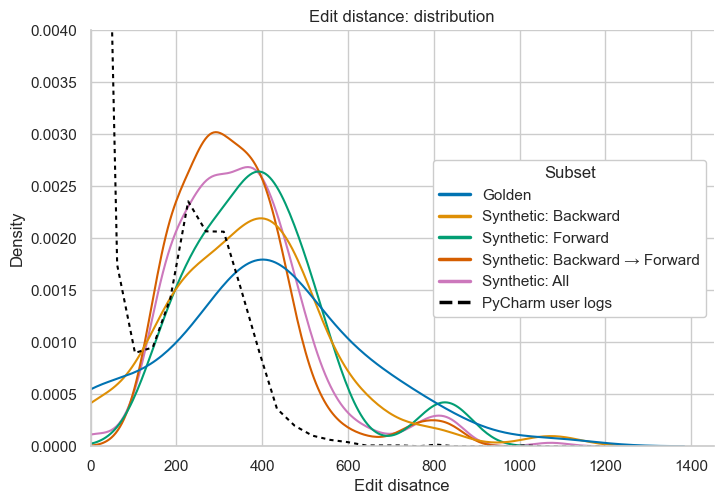

In [151]:
name = 'editdist'

sns.set_theme(palette="colorblind", style='whitegrid')

ax = sns.displot(data=load_data(name),
                 x='value',
                 hue='Subset',
                 kind='kde',
                 aspect=1.5,
                 common_norm=False,
                 legend=True,
                 clip=(0, 10000))

ax.set(xlim=(0, None))
ax.set(ylim=(0, 0.0040))

sns.lineplot(ax=ax.axes[0, 0], data=to_hist(FUS_DATA_NO_HEAD["CommitMessageEditDistance"]), x='x', y='y', style=True,
             dashes=[(2, 2)], color='black', legend=False)


handles = list(ax.legend.get_lines())
labels = [t.get_text() for t in ax.legend.get_texts()]

from matplotlib.legend import Legend

leg = Legend(parent=ax.axes[0, 0], handles=handles + [fus_line], labels=labels + ['PyCharm user logs'], loc='center right', frameon=True, title='Subset', framealpha=1.)
ax._legend.remove()
ax.axes[0, 0].add_artist(leg)


for line in leg.get_lines():
    line.set_linewidth(2.5)

plt.title(f"Edit distance: distribution")
plt.xlabel("Edit disatnce")

plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.png", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.svg", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.pdf", bbox_inches='tight')
plt.show()

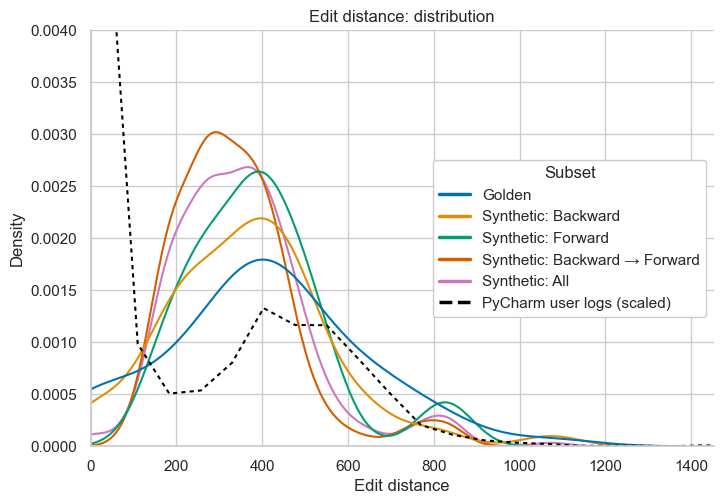

In [152]:
PROD_LENGTH_RATIO = 1.772691712591923

name = 'editdist'

sns.set_theme(palette="colorblind", style='whitegrid')

ax = sns.displot(data=load_data(name),
                 x='value',
                 hue='Subset',
                 kind='kde',
                 aspect=1.5,
                 common_norm=False,
                 clip=(0, 10000))

ax.set(xlim=(0, None))
ax.set(ylim=(0, 0.0040))

FUS_EDIT_DISTANCE_SCALED = copy.deepcopy(FUS_DATA_NO_HEAD["CommitMessageEditDistance"])
FUS_EDIT_DISTANCE_SCALED['x'] = [e * PROD_LENGTH_RATIO for e in FUS_EDIT_DISTANCE_SCALED['x']]
FUS_EDIT_DISTANCE_SCALED['bin_size'] = [e * PROD_LENGTH_RATIO for e in FUS_EDIT_DISTANCE_SCALED['bin_size']]

sns.lineplot(data=to_hist(FUS_EDIT_DISTANCE_SCALED), x='x', y='y', style=True, dashes=[(2, 2)], color='black', legend=False)

handles = list(ax.legend.get_lines())
labels = [t.get_text() for t in ax.legend.get_texts()]

from matplotlib.legend import Legend

leg = Legend(parent=ax.axes[0, 0], handles=handles + [fus_line], labels=labels + ['PyCharm user logs (scaled)'], loc='center right', frameon=True, title='Subset', framealpha=1.)
ax._legend.remove()
ax.axes[0, 0].add_artist(leg)


for line in leg.get_lines():
    line.set_linewidth(2.5)
    

plt.title(f"Edit distance: distribution")
plt.xlabel("Edit distance")

plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_scaled_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.png",
            bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_scaled_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.svg",
            bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_scaled_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.pdf",
            bbox_inches='tight')
plt.show()

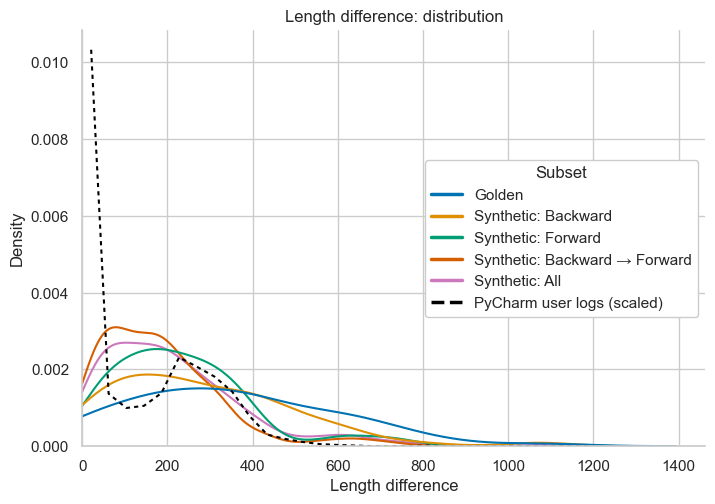

In [153]:
name = 'lendiff'

sns.set_theme(palette="colorblind", style='whitegrid')

ax = sns.displot(data=load_data(name),
                 x='value',
                 hue='Subset',
                 kind='kde',
                 aspect=1.5,
                 common_norm=False,
                 clip=(0, 10000))

ax.set(xlim=(0, None))

sns.lineplot(data=to_hist(FUS_DATA_NO_HEAD["CommitMessageLengthDiff"]), x='x', y='y', style=True, dashes=[(2, 2)], color='black', legend=False)

handles = list(ax.legend.get_lines())
labels = [t.get_text() for t in ax.legend.get_texts()]

from matplotlib.legend import Legend

leg = Legend(parent=ax.axes[0, 0], handles=handles + [fus_line], labels=labels + ['PyCharm user logs (scaled)'], loc='center right', frameon=True, title='Subset', framealpha=1.)
ax._legend.remove()
ax.axes[0, 0].add_artist(leg)


for line in leg.get_lines():
    line.set_linewidth(2.5)

plt.title(f"Length difference: distribution")
plt.xlabel("Length difference")

plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.png", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.svg", bbox_inches='tight')
plt.savefig(config.OUTPUT_CHARTS_DIR / f"{name}_fus_{FUS_REPORT_TYPE}_skip_{SKIP_FIRST}_dist.pdf", bbox_inches='tight')
plt.show()